# Manifold GP Supervised Learning via Precision Matrix

## Preamble

This notebook provides an example of how to perform Gaussian Process Regression on a 1D manifold. In this example we consider a supervised learning scenario, namely the number of labeled data points is equivalent to the number of the sampled points from the underlying manifold.

In [1]:
import numpy as np
import torch
import gpytorch
import matplotlib.pyplot as plt
from importlib.resources import files
from manifold_gp.kernels.riemann_matern_kernel import RiemannMaternKernel
from manifold_gp.models.riemann_gp import RiemannGP

Select the device: GPU or CPU.

In [2]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

## Load Dataset

In [3]:
data_path = files('manifold_gp.data').joinpath('dumbbell.msh')
data = np.loadtxt(data_path)
sampled_x = torch.from_numpy(data[:, :2]).float().to(device)
sampled_y = torch.from_numpy(data[:, -1]).float().to(device)
(m, n) = sampled_x.shape

## Apply Noise to the Dataset

In order to simulate real case scenario we can apply a normally distributed noise to our dataset. Here we can consider to apply the noise either to the sampled data points from the manifold or to the ground truth relative to each labeled points.

### Apply noise to the manifold
Setting the variable `manifold_noise` you can apply Gaussian noise to the sampled points from the manifold.

In [4]:
manifold_noise = 0.0
noisy_x = sampled_x + manifold_noise * torch.randn(m, n).to(device)

### Apply noise to the ground truth
Setting the variable `function_noise` you can apply Gaussian noise to the training points.

In [5]:
function_noise = 0.01
noisy_y = sampled_y + function_noise * torch.randn(m).to(device)

## Training Dataset

Create the training dataset. You can set the variable `num_train` to define the number of points within your dataset.

In [6]:
num_train = 100
train_idx = torch.randperm(m)[:num_train]
train_x = noisy_x[train_idx, :]
train_y = noisy_y[train_idx]

## Test Dataset

Create the training dataset. You can set the variable `num_test` to define the number of points within your dataset.

In [7]:
num_test = 50
test_idx = torch.randperm(m)[:num_test]
test_x = noisy_x[test_idx, :]
test_y = noisy_y[test_idx]

## Initialize Kernel

Create the Riemann Matern kernel. `nu` control the kernel smoothness like in the stadard Matern kernel. `neighbors` set the number of nearest neighbors in the KNN-based discrete approximation of the Laplace-Beltrami operator and construction of differentiable eigenfunctions. `modes` set the number of the eigenfunctions used to approximate the Riemann Matern kernel. As for classical *GPyTorch* kernels the Riemann Matern kernel can be decorated using with the *ScaleKernel* to have the signal variance parameter.

In [8]:
nu = 2
neighbors = 5
modes = 10
kernel = gpytorch.kernels.ScaleKernel(RiemannMaternKernel(sampled_x, nu, neighbors, modes))

## Initialize Likelihood and GP Model

Define the type of likelihood and the GP model. The GP model takes as input the training set and and labels, the likelihood and the Riemann Matern Kernel.

In [9]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
model = RiemannGP(sampled_x, sampled_y, likelihood, kernel).to(device)

## Train Model

Train the GP model using the fast Lanczos precision matrix optimization. `lr` set the learning rate; `iters` defines the number of iteratios; `verbose` can be set to `True` for printing the parameters each iteration.

In [10]:
lr = 1e-1
iters = 50
verbose = True
model.manifold_informed_train(lr, iters, verbose)

Iteration: 0, Loss: 9855.831, Noise Variance: 0.007, Signal Variance: 1.000, Lengthscale: 0.368, Epsilon: 0.135
Iteration: 1, Loss: 6059.193, Noise Variance: 0.007, Signal Variance: 1.064, Lengthscale: 0.400, Epsilon: 0.123
Iteration: 2, Loss: 3744.149, Noise Variance: 0.008, Signal Variance: 1.128, Lengthscale: 0.433, Epsilon: 0.112
Iteration: 3, Loss: 2329.780, Noise Variance: 0.009, Signal Variance: 1.191, Lengthscale: 0.466, Epsilon: 0.102
Iteration: 4, Loss: 1454.762, Noise Variance: 0.010, Signal Variance: 1.251, Lengthscale: 0.498, Epsilon: 0.094
Iteration: 5, Loss: 903.356, Noise Variance: 0.010, Signal Variance: 1.307, Lengthscale: 0.530, Epsilon: 0.086
Iteration: 6, Loss: 548.648, Noise Variance: 0.011, Signal Variance: 1.360, Lengthscale: 0.560, Epsilon: 0.079
Iteration: 7, Loss: 315.758, Noise Variance: 0.011, Signal Variance: 1.410, Lengthscale: 0.590, Epsilon: 0.073
Iteration: 8, Loss: 159.925, Noise Variance: 0.012, Signal Variance: 1.456, Lengthscale: 0.617, Epsilon: 0.

## Model Evaluation

In [11]:
%%capture
likelihood.eval()
model.eval()

Getting faster predictive distributions using [LOVE](https://arxiv.org/abs/1803.06058). We compute the **mean**, the **standard deviation** and one **posterior sample**. In addition we evaluate the kernel at the first point of our dataset.

In [12]:
%%capture
with torch.no_grad(), gpytorch.settings.fast_pred_var():
    preds = likelihood(model(sampled_x))
    mean = preds.mean
    std = preds.variance.sqrt()
    posterior_sample = preds.sample()
    kernel_eval = kernel(sampled_x[0, :].unsqueeze(0), sampled_x).evaluate().squeeze()

## Plot

Plot the results.

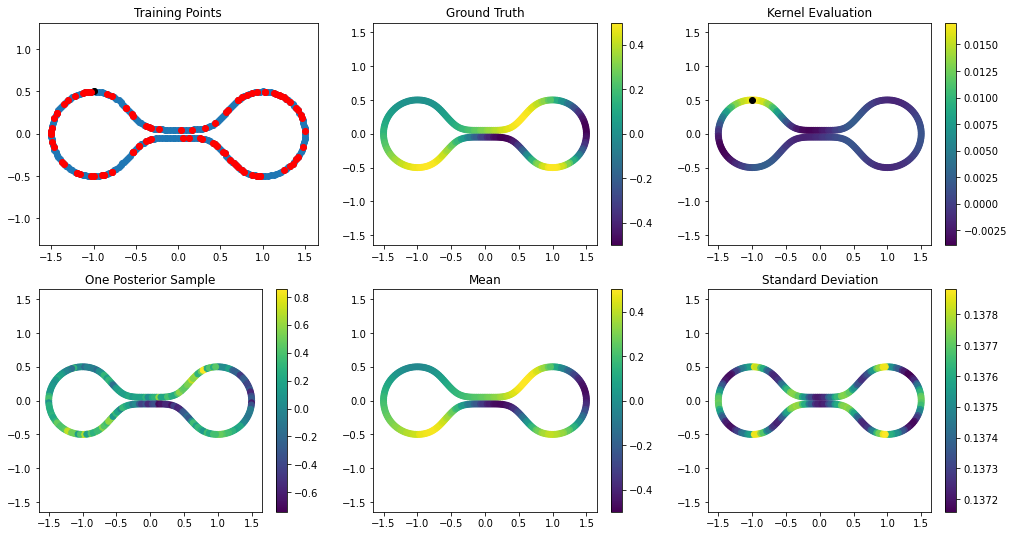

In [13]:
with torch.no_grad():
    fig = plt.figure(figsize=(17, 9))

    # Bring data to cpu
    if use_cuda:
        sampled_x = sampled_x.cpu()
        sampled_y = sampled_y.cpu()
        train_x = train_x.cpu()
        kernel_eval = kernel_eval.cpu()
        posterior_sample = posterior_sample.cpu()
        mean = mean.cpu()
        std = std.cpu()

    # Sampled Points
    ax = fig.add_subplot(231)
    ax.scatter(sampled_x[:, 0], sampled_x[:, 1])
    ax.scatter(sampled_x[0, 0], sampled_x[0, 1], c='k')
    ax.scatter(train_x[:, 0], train_x[:, 1], c="r", edgecolors="r")
    ax.axis('equal')
    ax.set_title('Training Points')

    # Ground Truth
    ax = fig.add_subplot(232)
    plot = ax.scatter(sampled_x[:, 0], sampled_x[:, 1],
                      c=sampled_y, vmin=-0.5, vmax=0.5)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Ground Truth')

    # Kernel evaluation
    ax = fig.add_subplot(233)
    plot = ax.scatter(sampled_x[:, 0], sampled_x[:, 1], c=kernel_eval)
    ax.scatter(sampled_x[0, 0], sampled_x[0, 1], c='k')
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Kernel Evaluation')

    # One Posterior Sample
    ax = fig.add_subplot(234)
    plot = ax.scatter(sampled_x[:, 0], sampled_x[:, 1], c=posterior_sample)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('One Posterior Sample')

    # Mean
    ax = fig.add_subplot(235)
    plot = ax.scatter(sampled_x[:, 0], sampled_x[:, 1],
                      c=mean, vmin=-0.5, vmax=0.5)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Mean')

    # Standard Deviation
    ax = fig.add_subplot(236)
    plot = ax.scatter(sampled_x[:, 0], sampled_x[:, 1], c=std)
    fig.colorbar(plot)
    ax.axis('equal')
    ax.set_title('Standard Deviation')